In [1]:
# Run if on Google Colab
import os
if os.path.isdir('/content/dsml_final_project'):
  !rm -rf /content/dsml_final_project
if not os.path.isdir('/content/saved_models'):
  !mkdir /content/saved_models
!cd /content; git clone --branch wesley_branch https://github.com/wglao/dsml_final_project.git
import sys
sys.path.append('/content/dsml_final_project')
!pip install wandb
!pip install --upgrade torch torchvision torchaudio

Cloning into 'dsml_final_project'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 406 (delta 0), reused 0 (delta 0), pack-reused 377
Receiving objects: 100% (406/406), 381.22 KiB | 4.24 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [2]:
# imports
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from models.models import MLP, MLPFunction, ResNet, Siren, SirenTrunk, TrunkNet, DeepONet
from utils.data import PatientDataset
from utils.train import naive_train, noisy_train_mlp, noisy_train_onet, noisy_train_MLPF, timeseries_MSE_loss, timeseries_L2_loss, timeseries_H1_loss

torch.set_float32_matmul_precision('high')

In [3]:
HIDDEN_LAYERS = 3
HIDDEN_SIZE = 320
SEED = 5678
NUM_EPOCHS = 2500
PRINT_EVERY = 500
LEARNING_RATE = 1e-4
BATCH_SIZE = 10
WANDB = False
DT = 1.
NOISE_VAR = 0.01

torch.manual_seed(SEED)

# branch and trunk nets
BASIS_DIM = 96

branch_dict = {
    "Net": Siren,
    "Args":{
      "in_size": 13,
      "hidden_size": HIDDEN_SIZE,
      "out_size": BASIS_DIM,
      "layers": HIDDEN_LAYERS,
      "freq_mod": 30.
    },
}

trunk_dict = {
    "Net": SirenTrunk,
    "Args":{
      "hidden_size": HIDDEN_SIZE,
      "basis_dims": BASIS_DIM,
      "layers": HIDDEN_LAYERS,
      "freq_mod": 30.
    },
}


In [4]:
# data
health_data_file = "/content/dsml_final_project/data/heart_failure_clinical_records_dataset.csv"
survival_file = "/content/dsml_final_project/data/survival_function_data.csv"

train_split = 90
num_patients = 299
ids = np.random.permutation(num_patients)
split_id = int((num_patients*train_split)//100)
train_ids = ids[:split_id]
test_ids = ids[split_id:]

train_dataset = PatientDataset(health_data_file, survival_file, train_ids)
test_dataset = PatientDataset(health_data_file, survival_file, test_ids)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

In [5]:
# model and optimizer
mlp_model = torch.compile(MLPFunction(13, HIDDEN_SIZE, 1, HIDDEN_LAYERS, act=F.gelu).cuda())
onet_model = torch.compile(DeepONet(branch_dict, trunk_dict).cuda())

mlp_optimizer = Adam(mlp_model.parameters(), LEARNING_RATE)
onet_optimizer = Adam(onet_model.parameters(), LEARNING_RATE)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [6]:
save_dir = "/content/saved_models"
# MLP
NET_NAME = "mlpf_test"
noisy_train_MLPF(mlp_model, mlp_optimizer, train_loader, test_loader, NUM_EPOCHS, loss_fn=timeseries_MSE_loss, log_wandb=WANDB, name=NET_NAME+"_MSE_loss", print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_loss=0.01)
# DeepONet
NET_NAME = "onet_test"
noisy_train_onet(onet_model, onet_optimizer, train_loader, test_loader, NUM_EPOCHS, loss_fn=timeseries_MSE_loss, log_wandb=WANDB, name=NET_NAME+"_MSE_loss", print_every=PRINT_EVERY, save_dir=save_dir, dt=DT, noise_variance=NOISE_VAR, range_loss=0.01, ortho_loss=0.)

Epoch: 0   Train: 1134.251754195602 (391.8360595703125)   Test: 418.8126627604167
Epoch: 500   Train: 0.500932835318424 (0.260775625705719)   Test: 0.983555277188619
Epoch: 1000   Train: 0.41006585569293413 (0.3015711307525635)   Test: 0.739586591720581
Epoch: 1500   Train: 0.269548413378221 (0.17209942638874054)   Test: 0.5031155248483022
Epoch: 2000   Train: 0.23154762939170556 (0.06752889603376389)   Test: 0.7819714496533076
Epoch: 2499   Train: 0.23886531149899518 (0.1476116180419922)   Test: 1.0547492802143097
Epoch: 0   Train: 9045.18654152199 (8490.1005859375)   Test: 10368.513346354166   Non-Ortho: 25.847932815551758
Epoch: 500   Train: 159.8998006184896 (109.91175079345703)   Test: 165.63938903808594   Non-Ortho: 18.17055320739746
Epoch: 1000   Train: 147.28188832600912 (91.17990112304688)   Test: 174.06175740559897   Non-Ortho: 12.434876441955566
Epoch: 1500   Train: 138.26134307296186 (87.8703384399414)   Test: 145.7404530843099   Non-Ortho: 11.155792236328125
Epoch: 2000   

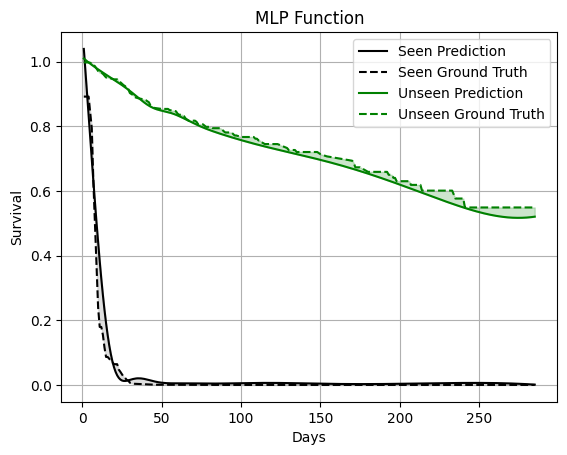

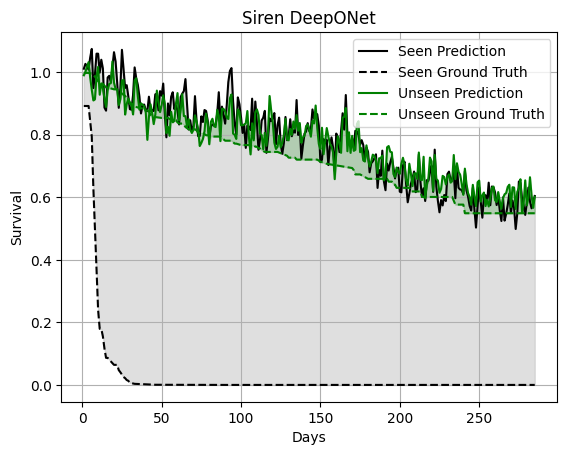

In [7]:
# inference
import matplotlib.pyplot as plt
seen_patient, seen_truth = train_dataset[-10]
unseen_patient, unseen_truth = test_dataset[-10]

times = torch.linspace(0,1,285)[:,None].cuda()
for model, model_type in zip([mlp_model, onet_model],["MLP Function", "Siren DeepONet"]):
  model.eval()

  seen_pred = torch.as_tensor(model(seen_patient.cuda()[None,:], times))
  unseen_pred = torch.as_tensor(model(unseen_patient.cuda()[None,:], times))

  if isinstance(seen_truth, torch.Tensor):
    seen_truth = seen_truth.detach().numpy()
    unseen_truth = unseen_truth.detach().numpy()
  seen_pred = seen_pred.cpu().detach().numpy()
  unseen_pred = unseen_pred.cpu().detach().numpy()


  if len(seen_pred.shape) > 1:
    seen_pred = np.reshape(seen_pred, (-1))
    unseen_pred = np.reshape(unseen_pred, (-1))

  fig, ax = plt.subplots(1,1)
  days = np.arange(1,286)
  ax.plot(days, seen_pred, "-k", label="Seen Prediction")
  ax.plot(days, seen_truth, "--k", label="Seen Ground Truth")
  ax.plot(days, unseen_pred, "-g", label="Unseen Prediction")
  ax.plot(days, unseen_truth, "--g", label="Unseen Ground Truth")
  ax.fill_between(days, np.min(np.vstack([seen_pred, seen_truth]), axis=0), np.max(np.vstack([seen_pred, seen_truth]), axis=0), color="silver", alpha=0.5)
  ax.fill_between(days, np.min(np.vstack([unseen_pred, unseen_truth]), axis=0), np.max(np.vstack([unseen_pred, unseen_truth]), axis=0), color="green", alpha=0.2)
  plt.grid(True)
  plt.title(f"{model_type}")
  plt.xlabel("Days")
  plt.ylabel("Survival")
  plt.legend(loc='best')
  plt.savefig(f"{save_dir}/{NET_NAME}_inference.png")
  plt.show()

Text(0.5, 1.0, 'Siren Basis Orthogonality')

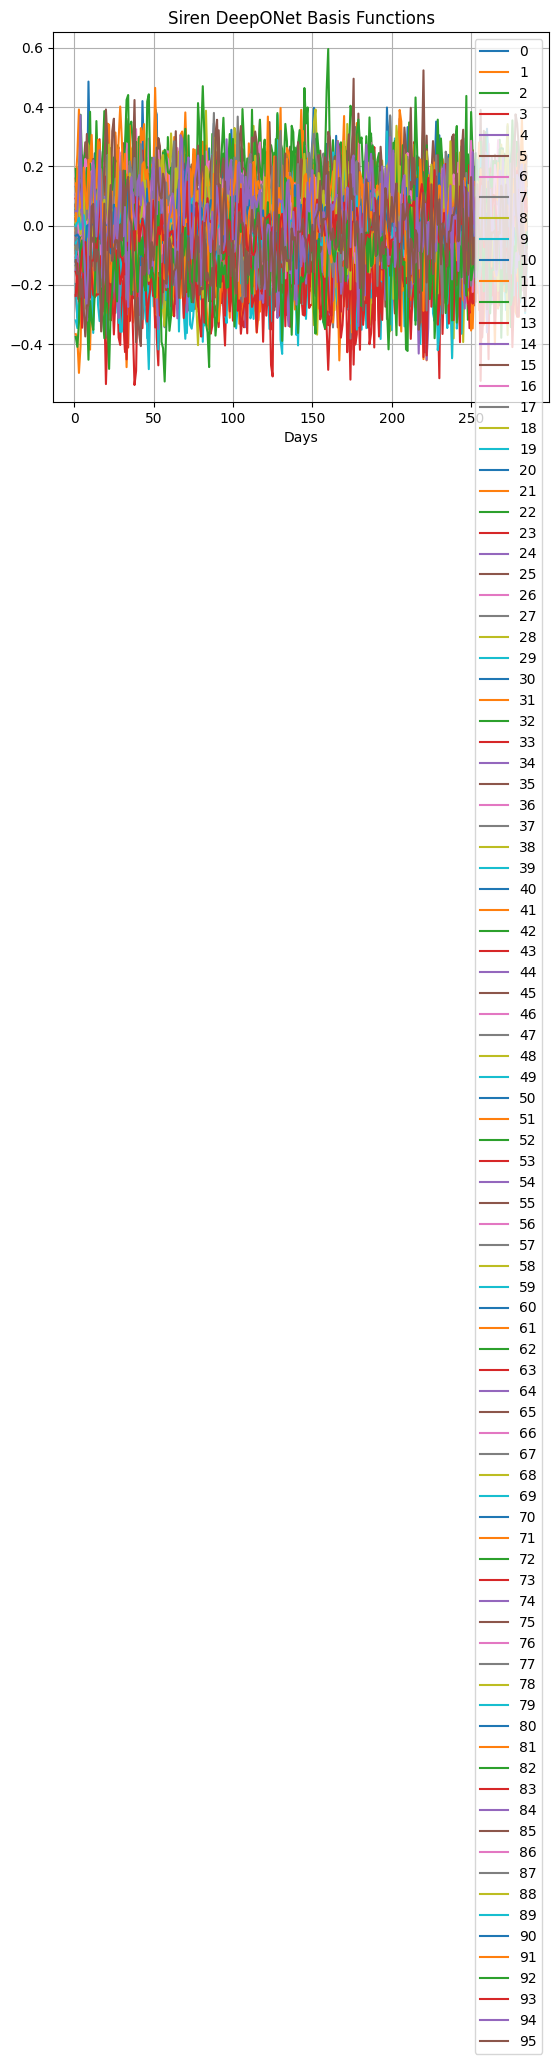

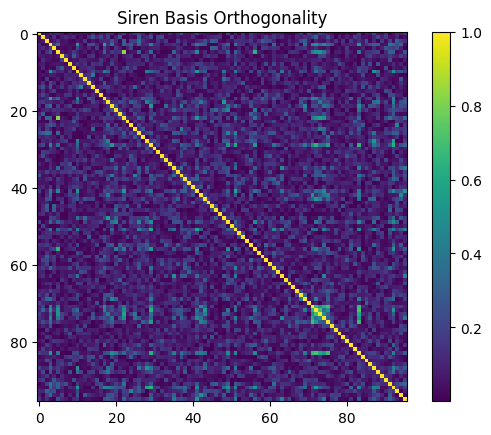

In [8]:
# plot basis
for model, model_type in zip([onet_model],["Siren DeepONet"]):
  v = model.trunk_net(times).cpu().detach().numpy()
  fig, ax = plt.subplots(1,1)
  days = np.arange(1,286)
  for i, f in enumerate(v.T):
    ax.plot(days, f, label=str(i))
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f"{model_type} Basis Functions")
  plt.xlabel("Days")

weights = np.ones(285)
weights[0] = 0.5
weights[-1] = 0.5
weights = np.diag(weights)

v1 = onet_model.trunk_net(times).cpu().detach().numpy()
v1_norms = np.sqrt(np.diag(v1.T @ weights @ v1))
v1 = v1 / v1_norms

v1_ortho = np.abs(v1.T @ weights @ v1)

fig, ax = plt.subplots(1,1)
plt.imshow(v1_ortho)
plt.colorbar()
plt.title("Siren Basis Orthogonality")

In [9]:
print(np.linalg.matrix_rank(v1, 1e-6))

96


In [10]:
print(onet_model.trunk_net.body.hidden_freqs)

Parameter containing:
tensor([[[29.8481]],

        [[29.3874]]], device='cuda:0', requires_grad=True)
